- XGB Regression   
하이퍼파라미터 조정 결과 : {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 400, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}   
mse: 1.6046701799206127, rmse:1.2667557696417304 
- SVM Regression
하이퍼파라미터 조정 결과 : {'kernel': 'rbf', 'gamma': 0.03, 'C': 30}   
mse: 1.7905607098643779 , rmse:1.338118346733344 

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,770 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import xgboost
from sklearn.svm import LinearSVR, SVR
from sklearn.metrics import explained_variance_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/Colab Notebooks'
try:
    os.chdir(PATH) 
    print("Directory changed")
except OSError:
    print("Can't change the Current Working Directory")

Directory changed


In [5]:
import platform
if platform.system() == 'Darwin': 
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': 
        plt.rc('font', family='NanumBarunGothic') ## google colab
plt.rcParams['axes.unicode_minus'] = False

In [23]:
data = pd.read_excel("final_data.xlsx")
data

,yyyymmdd,area,sex,frequency,최저기온,최고기온,일평균기온,일평균습도,강수량,적설,...,흉부외과,흡연율,병실수,보건시설,공장수,SO2,CO,O3,NO2,PM10
0,2012-01-01,강원,1,3,-13.9,6.0,-7.4000,70.000,2.857143,0.0,...,30,26.2,20959,245,2877,0.010033,1.012879,0.019098,0.020873,81.560300
1,2012-01-01,강원,2,3,-13.9,6.0,-7.4000,70.000,2.857143,0.0,...,30,26.2,20959,245,2877,0.010033,1.012879,0.019098,0.020873,81.560300
2,2012-01-01,경기,1,4,-12.2,1.1,-6.2875,67.625,0.000000,0.0,...,169,24.5,123168,334,54213,0.009092,0.962206,0.012449,0.030763,85.343681
3,2012-01-01,경기,2,5,-12.2,1.1,-6.2875,67.625,0.000000,0.0,...,169,24.5,123168,334,54213,0.009092,0.962206,0.012449,0.030763,85.343681
4,2012-01-01,경남,1,2,-8.9,8.0,1.6500,55.625,0.000000,0.0,...,52,24.1,56963,410,15305,0.008975,0.653175,0.021261,0.017499,62.009501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,2015-12-31,제주,2,0,3.5,12.5,6.6250,54.375,0.000000,0.0,...,17,21.3,5628,63,675,0.002903,0.539426,0.034771,0.009910,74.854167
49670,2015-12-31,충남,1,0,-7.0,8.0,-1.6250,76.250,0.000000,0.0,...,38,23.4,29816,400,8477,0.004571,0.786250,0.017996,0.019843,53.587500
49671,2015-12-31,충남,2,0,-7.0,8.0,-1.6250,76.250,0.000000,0.0,...,38,23.4,29816,400,8477,0.004571,0.786250,0.017996,0.019843,53.587500
49672,2015-12-31,충북,1,1,-8.0,6.7,-0.2250,71.625,0.000000,0.0,...,29,22.2,21007,266,7167,0.005597,0.849564,0.009818,0.028704,63.086927


변수추가: 일교차, 계절, 주말

In [24]:
data['일교차'] = data['최고기온'] - data['최저기온']

In [ ]:
data['일교차'] = data['최고기온'] - data['최저기온']
spring = data[(data.yyyymmdd.dt.month >= 3) & (data.yyyymmdd.dt.month <= 5)].index
summer = data[(data.yyyymmdd.dt.month >= 6) & (data.yyyymmdd.dt.month <= 8)].index
fall = data[(data.yyyymmdd.dt.month >= 9) & (data.yyyymmdd.dt.month <= 11)].index
winter = data[(data.yyyymmdd.dt.month == 12) | (data.yyyymmdd.dt.month <= 2)].index
data.loc[spring, 'season'] = '봄'
data.loc[summer, 'season'] = '여름'
data.loc[fall, 'season'] = '가을'
data.loc[winter, 'season'] = '겨울'
weekend = data[(data.yyyymmdd.dt.dayofweek == 5) | (data.yyyymmdd.dt.dayofweek == 6)].index
data['weekend'] = 0
data.loc[weekend, 'weekend'] = 1

In [26]:
weekend = data[(data.yyyymmdd.dt.dayofweek == 5) | (data.yyyymmdd.dt.dayofweek == 6)].index
data['weekend'] = 0
data.loc[weekend, 'weekend'] = 1

원 핫 인코딩

In [27]:
data_ohe = pd.get_dummies(data, columns = ['sex', 'area', 'season'])
data_ohe.head(2)

,yyyymmdd,frequency,최저기온,최고기온,일평균기온,일평균습도,강수량,적설,간호사,고령인구비율,...,area_인천,area_전남,area_전북,area_제주,area_충남,area_충북,season_가을,season_겨울,season_봄,season_여름
0,2012-01-01,3,-13.9,6.0,-7.4,70.0,2.857143,0.0,3983,15.7,...,0,0,0,0,0,0,0,1,0,0
1,2012-01-01,3,-13.9,6.0,-7.4,70.0,2.857143,0.0,3983,15.7,...,0,0,0,0,0,0,0,1,0,0


train - validation split

In [28]:
df_train = data_ohe.drop(columns = ['frequency']) 
target_train = data_ohe['frequency'] 

X_train, X_val, y_train, y_val = train_test_split(df_train, target_train, test_size=0.2, random_state=42, shuffle=True) 
X_train.reset_index(inplace=True, drop=True); y_train = y_train.reset_index(drop=True)
X_val.reset_index(inplace=True,drop=True); y_val = y_val.reset_index(drop=True)

변수 스케일링: RobustScaler 사용(이상치에 덜 민감)   
train set에만 transform & fit, validation set에는 fit만

In [12]:
scaler = RobustScaler()
scaler_col = [i for i in X_train.iloc[:,5:30].columns]
scaler.fit(X_train[scaler_col])
X_train[scaler_col] = pd.DataFrame(scaler.transform(X_train[scaler_col]), columns=scaler_col)
X_val[scaler_col] = pd.DataFrame(scaler.transform(X_val[scaler_col]), columns=scaler_col)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49674 entries, 0 to 49673
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   yyyymmdd   49674 non-null  datetime64[ns]
 1   area       49674 non-null  object        
 2   sex        49674 non-null  int64         
 3   frequency  49674 non-null  int64         
 4   최저기온       49674 non-null  float64       
 5   최고기온       49674 non-null  float64       
 6   일평균기온      49674 non-null  float64       
 7   일평균습도      49674 non-null  float64       
 8   강수량        49674 non-null  float64       
 9   적설         49674 non-null  float64       
 10  간호사        49674 non-null  int64         
 11  고령인구비율     49674 non-null  float64       
 12  구급인력       49674 non-null  int64         
 13  구급차        49674 non-null  int64         
 14  병원         49674 non-null  int64         
 15  비만율        49674 non-null  float64       
 16  상급종합병원     49674 non-null  int64        

단계적 회귀: '요양병원', '약국', '보건시설', '병원', '종합병원', '병실수', '강수량', 'O3', 'PM10', 'CO', 'NO2'
라쏘(중요도 순 나열): 간호사, 병실수, 공장수 > 약국, 보건시설 > 구급인력, 구급차 >  PM10, 병원, 요양병원, 응급의학과, 종합, 흉부외과, 공장수, 최저기온, 강수량 > 고령인구비율, 상급종합병원, 신경외과, 흡연율, 최고기온, 일평균기온, 일평균습도 > 적설, 비만율 >나머지
랜덤포레스트(중요도 순 나열): 종합병원, 구급차, 상급종합병원, 응급의학과, 구급인력, 간호사, 병실수, 신경외과, 병원, 흉부외과, 약국, NO2, 공장수, O3

In [13]:
X_train.columns

Index(['yyyymmdd', '최저기온', '최고기온', '일평균기온', '일평균습도', '강수량', '적설', '간호사',
       '고령인구비율', '구급인력', '구급차', '병원', '비만율', '상급종합병원', '신경외과', '약국', '요양병원',
       '응급의학과', '종합병원', '흉부외과', '흡연율', '병실수', '보건시설', '공장수', 'SO2', 'CO', 'O3',
       'NO2', 'PM10', '일교차', 'weekend', 'sex_1', 'sex_2', 'area_강원', 'area_경기',
       'area_경남', 'area_경북', 'area_광주', 'area_대구', 'area_대전', 'area_부산',
       'area_서울', 'area_세종', 'area_울산', 'area_인천', 'area_전남', 'area_전북',
       'area_제주', 'area_충남', 'area_충북', 'season_가을', 'season_겨울', 'season_봄',
       'season_여름'],
      dtype='object')

In [14]:
x_variables = ['병원', '약국', '병실수', '간호사', '구급인력', '종합병원', 'O3', 'PM10', '일평균기온', '일평균습도']

XGBRegressor

In [ ]:
xgb = xgboost.XGBRegressor()
xgb_param_grid = {'objective':['reg:linear'], 
              'learning_rate': [.03, 0.05, .07, .1], # xgb's eta
              'max_depth': [3, 4, 5, 6], # 3~6
              'min_child_weight': [4], 
              'silent': [1], # warning - verbosity
              'subsample': [0.7], # 70% 비율로 각 단계마다 로우 샘플링
              'colsample_bytree': [0.7], # 70% 비율로 각 트리마다 칼럼 샘플링
              'n_estimators': [100, 200, 300, 400, 500]} 

xgb_grid = GridSearchCV(xgb,
                        xgb_param_grid,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train[x_variables], y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
0.45274809523209314
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 400, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [ ]:
result_df = pd.DataFrame(xgb_grid.cv_results_)
result_df.sort_values(by=['rank_test_score'],inplace=True)

result_df[['params','mean_test_score','rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
3,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.452748,1
41,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.452747,2
4,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.452631,3
21,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.452529,4
2,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.452486,5
22,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.452340,6
60,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.452117,7
42,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.451758,8
7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.451564,9
26,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.451387,10


{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 400, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

In [15]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=3, min_child_weight=4, n_estimators=400, objective='reg:linear', silent=1, subsample=0.7)
xgb_model.fit(X_train[x_variables], y_train)
y_pred = xgb_model.predict(X_val[x_variables])
xgb_mse = mean_squared_error(y_val, y_pred)

In [16]:
xgb_mse

1.6046701799206127

In [17]:
xgb_rmse = mean_squared_error(y_val, y_pred, squared = False)

In [21]:
xgb_rmse

1.2667557696417304

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48337 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_

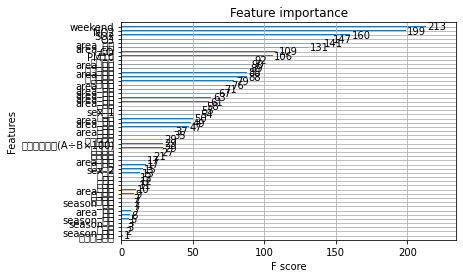

In [ ]:
xgboost.plot_importance(xgb_model)

SVMRegressor

In [ ]:
svm_reg = SVR()
svm_grid = [
    {'kernel': ['linear'], 'C': [10, 20, 30, 50, 100]},
    {'kernel': ['rbf'], 'C':[10, 20, 30, 50, 100],
     'gamma':[.03, .07, .1, .15]}
]
gd_search = RandomizedSearchCV(svm_reg, svm_grid, cv=5,  verbose=3)
gd_search.fit(X_train[x_variables], y_train)

print(gd_search.best_score_)
print(gd_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'kernel': 'rbf', 'gamma': 0.03, 'C': 30}

In [18]:
svm_model = SVR(kernel='rbf', C=30, gamma=0.03)
svm_model.fit(X_train[x_variables], y_train)
y_pred = svm_model.predict(X_val[x_variables])
svm_mse = mean_squared_error(y_val, y_pred)

In [19]:
svm_mse

1.7905607098643779

In [20]:
rmse = np.sqrt(svm_mse)
rmse

1.338118346733344